<a href="https://colab.research.google.com/github/Sara-Esm/Natural-Language-Processing-NLP-and-generative-AI/blob/main/2_Word2Vec_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis Using LSTM and Word2Vec Embeddings

This project applies sentiment analysis to the Sentiment140 dataset containing tweets labeled as positive or negative. Key steps include preprocessing text data, training a Word2Vec model for embeddings, and building an LSTM-based neural network for classification. The model is evaluated using a classification report and confusion matrix for performance analysis.

In [15]:
## Install Required Libraries

# Install necessary libraries
!pip install kagglehub contractions gensim tensorflow scikit-learn matplotlib seaborn

In [16]:
## Downloading and Loading the Dataset

import kagglehub
import pandas as pd

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Download the Sentiment140 dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Dataset downloaded to:", path)

# Load the dataset
tweets = pd.read_csv(
    "/root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2/training.1600000.processed.noemoticon.csv",
    encoding='latin-1',
    names=["target", "ids", "date", "flag", "user", "text"]
)[["target", "text"]]

# Display the first few rows of the dataset
tweets

Dataset downloaded to: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [17]:
## Preprocessing Target Labels

# Convert positive sentiment labels (4) to 1
tweets["target"].loc[tweets["target"] == 4] = 1

# Check label distribution
tweets["target"].value_counts()

<ipython-input-17-f578d7560f28>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tweets["target"].loc[tweets["target"] == 4] = 1


,count
target,
0,800000
1,800000


In [18]:
## Downsampling the Dataset

# Shuffle and downsample the dataset
tweets = tweets.sample(frac=1, random_state=42).head(100000)
tweets.head()

,target,text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


In [19]:
## Preprocessing the Text

# Import necessary libraries
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import contractions

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize tools
lemmatizer = WordNetLemmatizer()
stopwrds = stopwords.words('english')

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)', '<web>', text)  # Replace URLs
    text = re.sub(r'@[^\s]+', '<user>', text)  # Replace user handles
    text = re.sub(r'#[^\s]+', '<hashtag>', text)  # Replace hashtags
    text = re.sub(r"[8:=;]['`\-]?[)d]+", '<smile>', text)  # Replace smile emojis
    text = re.sub(r"<3", '<heart>', text)  # Replace heart emojis
    text = re.sub(r"[8:=;]['`\-]?\(+", '<sad>', text)  # Replace sad emojis
    text = re.sub(r"[8:=;]['`\-]?p+", '<lol>', text)  # Replace laughing emojis
    for old, new in contractions.contractions_dict.items():  # Replace contractions
        text = text.replace(old, new)
    text = re.sub(r"[^a-z0-9<>]", ' ', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwrds])  # Lemmatize and remove stopwords
    return text

# Apply preprocessing
tweets["text"] = tweets["text"].apply(preprocess_text)
tweets.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,target,text
541200,0,<user> ahhh hope ok
750,0,<user> cool tweet apps razr 2
766711,0,<user> know family drama lame hey next time u ...
285055,0,school email open geography stuff revise stupi...
705995,0,upper airway problem


In [20]:
## Tokenization and Padding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tweets["text"])
x_data = pad_sequences(tokenizer.texts_to_sequences(tweets["text"]), maxlen=50)

# Train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, tweets["target"], test_size=0.1, random_state=42)

In [21]:
## Train Word2Vec Embeddings

from gensim.models import Word2Vec

# Prepare data for Word2Vec
documents = [text.split() for text in tweets["text"]]

# Train Word2Vec model
word2vec_model = Word2Vec(window=10, min_count=5, workers=8)
word2vec_model.build_vocab(documents, progress_per=10000)
word2vec_model.train(documents, total_examples=word2vec_model.corpus_count, epochs=30, report_delay=1)

(18725359, 23228670)

In [30]:
## Build and Train the LSTM Model

import numpy as np
from keras import Sequential, layers

# Create embedding matrix
len_words = len(tokenizer.word_index)
embedding_matrix = np.zeros((len_words + 1, 100))
for word, token in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[token] = word2vec_model.wv[word]

# Define the model
embedding_layer = layers.Embedding(len_words + 1, 100, weights=[embedding_matrix], input_length=50, trainable=False)

model = Sequential([
    embedding_layer,
    layers.Dropout(0.25),
    layers.LSTM(units=25),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Build the model explicitly
model.build(input_shape=(None, 50))  # Input shape: (batch_size, sequence_length)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 50, 100)             │       4,905,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25)                  │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,919,629 (18.77 MB)

 Trainable params: 14,329 (55.97 KB)

 Non-trainable params: 4,905,300 (18.71 MB)

In [32]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=64)

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.6978 - loss: 0.5717 - val_accuracy: 0.7509 - val_loss: 0.5004
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - accuracy: 0.7516 - loss: 0.5071 - val_accuracy: 0.7557 - val_loss: 0.4957
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.7553 - loss: 0.4953 - val_accuracy: 0.7582 - val_loss: 0.4880
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.7595 - loss: 0.4909 - val_accuracy: 0.7644 - val_loss: 0.4870
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 84s 31ms/step - accuracy: 0.7620 - loss: 0.4866 - val_accuracy: 0.7628 - val_loss: 0.4861


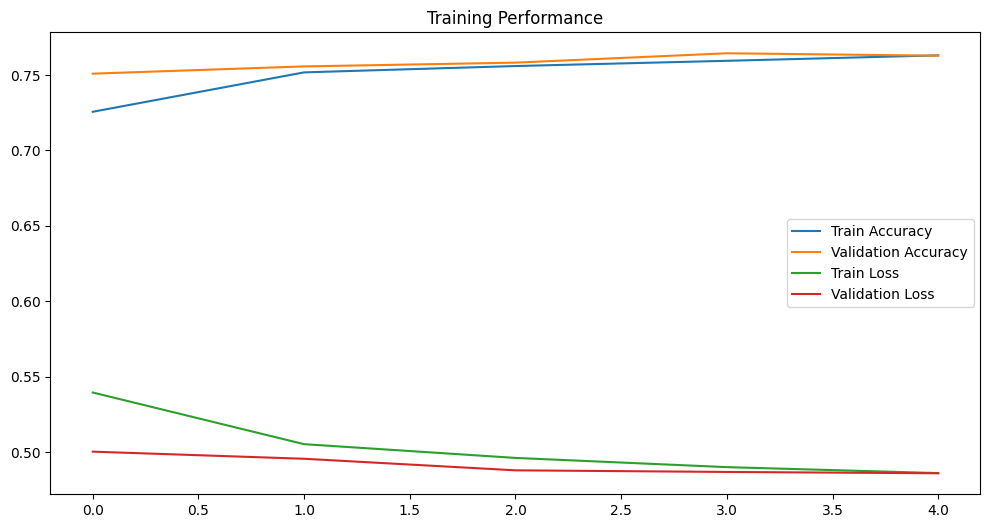

In [33]:
# Plot accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Performance")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      5045
           1       0.75      0.79      0.77      4955

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



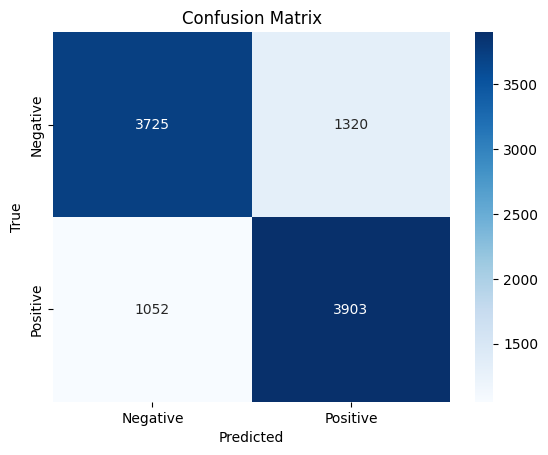

In [34]:
# Generate predictions
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
predictions = model.predict(x_test, batch_size=32)
predictions_rounded = np.round(predictions).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions_rounded))

# Confusion matrix
cm = confusion_matrix(y_test, predictions_rounded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()